<a href="https://colab.research.google.com/github/24p11/recode-scenario/blob/main/scenario_oncology_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Create fictive clinical notes from Code set (DRG + ICD)

Code set are the raw classification data, we can extract from National database (Base nationale PMSI en France). They are made of 
* classification profile made of grouping variables from DRG records which are prepared with their frequency in the national database
    - age (class)
    - sexe
    - DRG (racine GHM)
    - Main diagnosis (ICD10) : cf
    - Hospitalization management type : cf
* diagnosis associated to each classification profile, extracted with their frequencies
* procedures associated to each classification profile, specialy for surgery and technical gestures, extracted with their frequencies

From thoses raw information we produce a coded clinical scenario which will be uses a seed.

This scenario is transformed into a detail prompt that will be given to a LLM for generation.
From the combinaision of primary and related diagnosis in French discharge abstract, we derived two notions :
* Primary diagnosis : host the notion of principal pathology, it is rather the primary diagnosis of the discharge abstract or the related diagnosis when it exists and that the primary diagnosis of the discharge abstract is from the chapter "Facteurs influant sur l’état de santé" of ICD10
* The Hospitalization management type is rather the term "Primary diagnosis" or the ICD-10 code of the related diagnosis when it exists


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
from utils import *

In [5]:
gs = generate_scenario()
# Load official dictionaries
# col_names option allow you to algin your column names the project dictionary.
gs.load_offical_icd("cim_2024.xlsx",col_names={"code" : "icd_code","libelle":"icd_code_description"} )
gs.load_offical_procedures("ccam_actes_2024.xlsx",col_names={"code":"procedure","libelle_long":"procedure_description"} )
col_names={"Code CIM":"icd_parent_code","Localisation":"primary_site","Type Histologique":"histological_type",
           "Stade":"stage","Marqueurs Tumoraux":"biomarkers","Traitement":"treatment_recommandation","Protocole de Chimiothérapie":"chemotherapy_regimen"}
gs.load_cancer_treatement_recommandations("Tableau récapitulatif traitement cancer.xlsx",col_names ) 
col_names={"racine":"drg_parent_code","lib_spe_uma":"specialty","ratio_spe_racine":"ratio"}
gs.load_specialty_refential("dictionnaire_spe_racine.xlsx",col_names)
gs.load_referential_hospital("chu")
gs.load_exclusions("exclusions")

# Load data from BN  PMSI
col_names={"racine":"drg_parent_code","das": "icd_secondary_code","diag":"icd_primary_code","categ_cim":"icd_primary_parent_code",
            "mdp":"case_management_type","nb_situations":"nb","acte":"procedure",
            "mode_entree":"admission_mode",
            "mode_sortie":"discharge_disposition",
            "mode_hospit":"admission_type"}
gs.load_classification_profile("bn_pmsi_cases_20250819.csv", col_names)
gs.load_secondary_icd("bn_pmsi_related_diag_20250818.csv",col_names)
gs.load_procedures("bn_pmsi_procedures_20250818.csv",col_names)

In [55]:
#Prepare cases
df_profile = gs.df_classification_profile

array([[<AxesSubplot:title={'center':'nb'}>]], dtype=object)

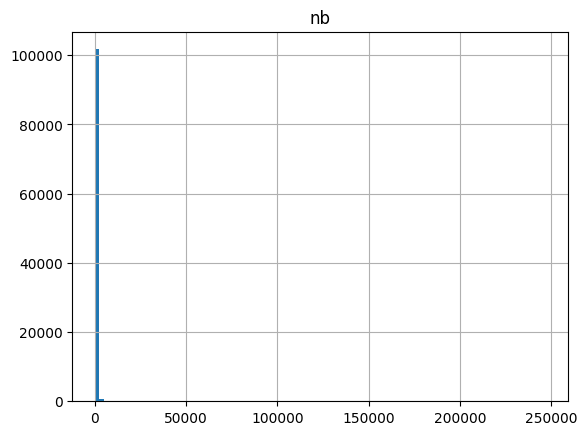

In [56]:
df_profile.hist(column="nb",bins=100)

In [58]:
n_tot_r = np.sum(df_profile.nb)
df_profile = df_profile.assign(effectif = df_profile.nb,
                    effectif_trans = np.sqrt(df_profile.nb)*1000000000/n_tot_r)
df_profile = df_profile.assign(effectif_final = np.where(df_profile.effectif_trans>1500,1500,df_profile.effectif_trans))


array([[<AxesSubplot:title={'center':'effectif_final'}>]], dtype=object)

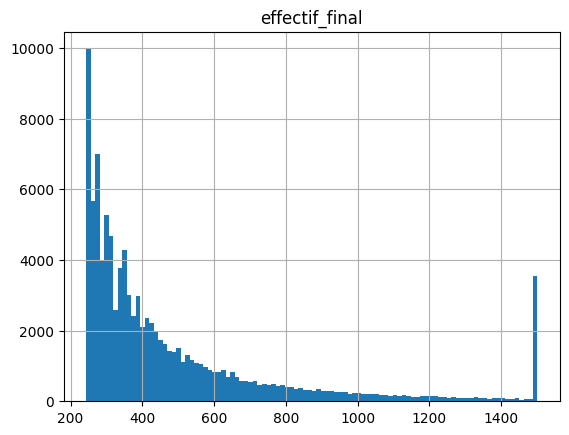

In [59]:
df_profile.hist(column="effectif_final",bins=100)

In [64]:
#Exclusion 
#G178	Transplantations d'organes
#G187	Séances : dialyse
#G189	Séances : radiothérapie
df_profile = df_profile[(~df_profile.ga.isin(gs.df_exclusions.ga) ) &(~df_profile.specialty.isin(["OBSTETRIQUE","NEONATOLOGIE"])) ]
print("Total classification profiles :  " + (str(len(df_profile))))

Total classification profiles :  98640


In [89]:
df_profile_sample = df_profile[~ (df_profile.icd_primary_code.isin(gs.icd_codes_cancer)) ].\
    sample(2000, weights="effectif_final").reset_index(drop=True)
df_profile_sample.drop(columns=["nb","effectif","effectif_trans","effectif_final"],inplace=True)

In [91]:
list_scenario = []

for i in tqdm(range(len(df_profile_sample))):
# for i in tqdm(range(1)):
    profile = df_profile_sample.iloc[i].copy()
    scenario = gs.generate_scenario_from_profile(profile)
    row = {k:scenario[k] for k in scenario.keys()}
    user_prompt = gs.make_prompts_marks_from_scenario(scenario)
    system_prompt = create_system_prompt(scenario)
    row["user_prompt"] = user_prompt
    row["system_prompt"] = system_prompt
    
    if  scenario["icd_primary_code"]  in gs.icd_codes_cancer  :
        prefix = """Le compte rendu suivant respecte les élements suivants :
        - les diagnostics ont une formulation moins formelle que la définition du code
        - le type histologique et la valeur des biomarqueurs si recherchés
        - le plan du CRH est conforme aux recommandations.
        """
    else :
        prefix = """Le compte rendu suivant respecte les élements suivants :
        - les diagnostics ont une formulation moins formelle que la définition du code
        - le plan du CRH est conforme aux recommandations.
        """
    
    row["prefix"] = prefix
    row["prefix_len"] = len(prefix)
    list_scenario.append(row)

 14%|█▍        | 1399/10000 [15:42:14<96:32:50, 40.41s/it]      


KeyboardInterrupt: 

In [ ]:
keep_cols = ['age',  'cage', 'cage2','sexe', 'date_entry', 'date_discharge', 'date_of_birth',
       'first_name', 'last_name', 'icd_primary_code', 'icd_primary_description', 'icd_parent_code',
       'case_management_type','case_management_type_description', 'case_management_type_text', 
       'drg_parent_code', 'drg_parent_description',
       'icd_secondaray_code',  'text_secondary_icd_official', 
        'procedure', 'text_procedure',
        'admission_type','admission_mode', 'discharge_disposition', 'dms', 'los_mean', 'los_sd',
       'cancer_stage', 'score_TNM', 'histological_type',
       'treatment_recommandation', 'chemotherapy_regimen', 'biomarkers',
       'first_name_med', 'last_name_med',
       'department','hospital',
       'cd_md_pec', 'user_prompt', 'system_prompt', 'prefix', 'prefix_len']
df_scenario = pd.DataFrame(list_scenario)[keep_cols]
df_scenario.to_csv("results/data_10000_20280827.csv")

,age,cage,cage2,sexe,date_entry,date_discharge,date_of_birth,first_name,last_name,icd_primary_code,...,biomarkers,first_name_med,last_name_med,department,hospital,cd_md_pec,user_prompt,system_prompt,prefix,prefix_len
0,84,[80-[,[50-[,1,2024-05-14,2024-05-24,1940-03-05,Nicole,Rosset-boulon,C800,...,None,Katica,Runigo,None,Nouvel Hôpital Civil - Hôpitaux Universitaires...,8,**SCÉNARIO DE DÉPART :**\n- Âge du patient : 8...,Vous êtes un oncologue clinicien expert. Votre...,Le compte rendu suivant respecte les élements ...,286
1,77,[70-80[,[50-[,1,2024-08-15,2024-08-15,1947-02-10,Celestin,Picher,C67,...,None,Danielle,Schisler,None,Hôpital Michallon - CHU Grenoble Alpes,15,**SCÉNARIO DE DÉPART :**\n- Âge du patient : 7...,Vous êtes un oncologue clinicien expert. Votre...,Le compte rendu suivant respecte les élements ...,286
2,56,[50-60[,[50-[,2,2024-05-24,2024-05-24,1968-02-21,Aurelie,Bies dit lapoudje,C795,...,None,Younesse,Doudot,None,Hôpital de Hautepierre - Hôpitaux Universitair...,16,**SCÉNARIO DE DÉPART :**\n- Âge du patient : 5...,Vous êtes un oncologue clinicien expert. Votre...,Le compte rendu suivant respecte les élements ...,286
3,73,[70-80[,[50-[,1,2024-01-09,2024-01-09,1950-08-23,Jean,Maubert,C182,...,None,Jean,St leon,None,Centre Hospitalier Lyon Sud - Hospices Civils ...,13,**SCÉNARIO DE DÉPART :**\n- Âge du patient : 7...,Vous êtes un oncologue clinicien expert. Votre...,Le compte rendu suivant respecte les élements ...,286
4,80,[80-[,[50-[,2,2024-06-05,2024-06-05,1943-11-22,Yvette,Aubin,C795,...,None,Gaël,Basta,None,Hôpital Cochin - Assistance Publique Hôpitaux ...,16,**SCÉNARIO DE DÉPART :**\n- Âge du patient : 8...,Vous êtes un oncologue clinicien expert. Votre...,Le compte rendu suivant respecte les élements ...,286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,68,[60-70[,[50-[,2,2024-07-19,2024-07-20,1956-05-16,Madeleine,Portail,C50,...,"ER/PR, HER2",Petru,Minassian,None,Hôpital Saint-Louis - Assistance Publique Hôpi...,12,**SCÉNARIO DE DÉPART :**\n- Âge du patient : 6...,Vous êtes chirurgien praticien. Votre tâche es...,Le compte rendu suivant respecte les élements ...,286
996,88,[80-[,[50-[,1,2024-04-11,2024-04-14,1935-11-15,Dion,Zappa,C182,...,CEA,Anoir,Badoraly,None,Centre Hospitalier Lyon Sud - Hospices Civils ...,16,**SCÉNARIO DE DÉPART :**\n- Âge du patient : 8...,Vous êtes un oncologue clinicien expert. Votre...,Le compte rendu suivant respecte les élements ...,286
997,59,[50-60[,[50-[,2,2024-06-18,2024-06-18,1964-11-15,Khadidia,Marquot,D381,...,None,Marie-jeanne,Choulet,None,Hôpital Roger Salengro - Centre Hospitalier Un...,13,**SCÉNARIO DE DÉPART :**\n- Âge du patient : 5...,Vous êtes un oncologue clinicien expert. Votre...,Le compte rendu suivant respecte les élements ...,286
998,25,[18-30[,[18-50[,1,2024-10-21,2024-10-21,1999-08-17,Christian,Givron,C819,...,None,Bérengère,Arnott,None,Hôpital Pellegrin - CHU de Bordeaux,13,**SCÉNARIO DE DÉPART :**\n- Âge du patient : 2...,Vous êtes un oncologue clinicien expert. Votre...,Le compte rendu suivant respecte les élements ...,286
